C:\Users\Harvey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Harvey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Harvey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Harvey\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pred

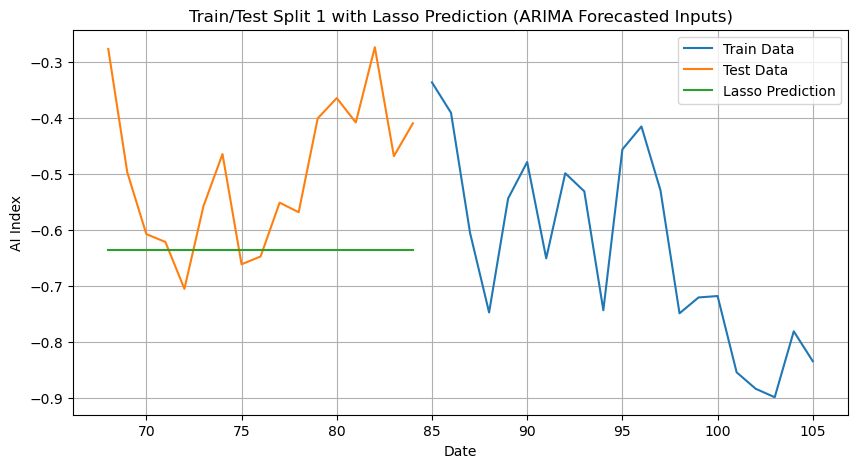

Split 1 Results (ARIMA Forecasted Inputs):
  Linear Regression: R² = -4.4167, MSE = 0.0876
  Ridge Regression: R² = -3.9902, MSE = 0.0807
  Lasso Regression: R² = -1.1689, MSE = 0.0351
  ElasticNet: R² = -1.1689, MSE = 0.0351
  KNN Regressor: R² = 0.0693, MSE = 0.0151
  SVR: R² = 0.1277, MSE = 0.0141
  Random Forest: R² = -0.5945, MSE = 0.0258
  Gradient Boosting: R² = -0.7830, MSE = 0.0288
  MLP Regressor: R² = -0.4564, MSE = 0.0236
--------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd, DateOffset
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv("C:/Users/Harvey/Downloads/merged_data (1).csv")

# Ensure 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.iloc[::-1]

# Time series split
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

# Dictionary to store results
model_results = {
    'Linear Regression': {'r2_scores': [], 'mse_scores': []},
    'Ridge Regression': {'r2_scores': [], 'mse_scores': []},
    'Lasso Regression': {'r2_scores': [], 'mse_scores': []},
    'ElasticNet': {'r2_scores': [], 'mse_scores': []},
    'KNN Regressor': {'r2_scores': [], 'mse_scores': []},
    'SVR': {'r2_scores': [], 'mse_scores': []},
    'Random Forest': {'r2_scores': [], 'mse_scores': []},
    'Gradient Boosting': {'r2_scores': [], 'mse_scores': []},
    'MLP Regressor': {'r2_scores': [], 'mse_scores': []}
}

# Define all regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'KNN Regressor': KNeighborsRegressor(),
    'SVR': SVR(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'MLP Regressor': MLPRegressor(max_iter=1000)
}

# Iterate through the time series split
iteration = 0
for train_index, test_index in tscv.split(df):
    iteration += 1
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
    
    # Forecast unemployment and inflation using ARIMA
    unemp_model = pm.auto_arima(train_df['Average Unemployment'], seasonal=False, suppress_warnings=True)
    infl_model = pm.auto_arima(train_df['Average Inflation'], seasonal=False, suppress_warnings=True)
    
    unemp_forecast = unemp_model.predict(n_periods=len(test_df))
    infl_forecast = infl_model.predict(n_periods=len(test_df))
    
    # Standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[['Average Unemployment', 'Average Inflation']])
    X_test = scaler.transform(np.column_stack((unemp_forecast, infl_forecast))) # Use forecasted values
    y_train = train_df['AI Index']
    y_test = test_df['AI Index']
    
    # Evaluate all models
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        # Store results
        model_results[name]['r2_scores'].append(r2)
        model_results[name]['mse_scores'].append(mse)

    # Plot train and test dates for each split (showing Lasso for brevity)
    plt.figure(figsize=(10, 5))
    plt.plot(train_df.index, y_train, label='Train Data')
    plt.plot(test_df.index, y_test, label='Test Data')
    plt.plot(test_df.index, models['Lasso Regression'].predict(X_test), label='Lasso Prediction')
    plt.title(f"Train/Test Split {iteration} with Lasso Prediction (ARIMA Forecasted Inputs)")
    plt.xlabel("Date")
    plt.ylabel("AI Index")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print R² and MSE for each model in this split
    print(f"Split {iteration} Results (ARIMA Forecasted Inputs):")
    for name in models.keys():
        r2 = model_results[name]['r2_scores'][iteration-1]
        mse = model_results[name]['mse_scores'][iteration-1]
        print(f"  {name}: R² = {r2:.4f}, MSE = {mse:.4f}")
    print("-" * 20)

# Calculate and print mean results for all models
print("\nModel Performance Across Time Series Splits (ARIMA Forecasted Inputs):")
print("---------------------------------------------")
for name, results in model_results.items():
    mean_r2 = np.mean(results['r2_scores'])
    mean_mse = np.mean(results['mse_scores'])
    r2_std = np.std(results['r2_scores'])
    mse_std = np.std(results['mse_scores'])
    max_r2 = np.max(results['r2_scores'])
    max_mse = np.max(results['mse_scores'])

    print(f"{name}:")
    print(f"  Mean R²: {mean_r2:.4f} (±{r2_std:.4f})")
    print(f"  Mean MSE: {mean_mse:.4f} (±{mse_std:.4f})")
    print(f"  Max R²: {max_r2:.4f}")
    print(f"  Max MSE: {max_mse:.4f}")
    print()

# Predict for the next 10 months using ARIMA forecast for inputs
last_date = df.index.max()
future_dates = [last_date + DateOffset(months=x) for x in range(1, 11)]

# Forecast unemployment and inflation for the next 10 months
unemp_model_full = pm.auto_arima(df['Average Unemployment'], seasonal=False, suppress_warnings=True)
infl_model_full = pm.auto_arima(df['Average Inflation'], seasonal=False, suppress_warnings=True)
unemp_forecast_future = unemp_model_full.predict(n_periods=10)
infl_forecast_future = infl_model_full.predict(n_periods=10)

# Scale the forecasted data
future_data_scaled = scaler.transform(np.column_stack((unemp_forecast_future, infl_forecast_future)))

future_predictions = {}
for name, model in models.items():
    # Retrain the model on the full dataset before predicting the future
    X_full = scaler.fit_transform(df[['Average Unemployment', 'Average Inflation']])
    y_full = df['AI Index']
    model.fit(X_full, y_full)
    predictions = model.predict(future_data_scaled)
    future_predictions[name] = predictions

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['AI Index'], label='Historical Data')
for name, preds in future_predictions.items():
    plt.plot(future_dates, preds, label=f'{name} Prediction (Next 10 Months, ARIMA Forecast)', marker='o') 
plt.title("Predictions for Next 10 Months (All Models, ARIMA Forecasted Inputs)")
plt.xlabel("Date")
plt.ylabel("Index")
plt.legend()
plt.grid(True)
plt.show()